In [1]:
import os
from os import path as osp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

collapse_test_sets = True

out_dir = osp.abspath('../data/results/plots')
if not osp.isdir(out_dir):
    os.makedirs(out_dir)

def independend_dependend_variable_from_df(dataframe, independent_col, dependent_col):
    return dataframe.groupby(independent_col)[dependent_col].apply(list)

def save_plot(filename, out_dir=out_dir, **kwargs):
    out_path = osp.join(out_dir, filename)
    plt.savefig(out_path, bbox_inches='tight', **kwargs)

def set_df_type(df):
    return df.astype({
        'e_tc_delta': float, 
        'd_tc_delta': float, 
        'token_idx': int
    })

sns_violin_plot_kwargs = {
    'cut': 0,
    'inner': 'quartile',
    'bw': .1
}

In [2]:
data_dir = osp.abspath('../data/results/analysis_outputs/')
files = sorted(os.listdir(data_dir))
files = [f for f in files if 'test' in f and 'lastall.json' in f]
print('available files:', *enumerate(files), sep='\n')

available files:
(0, 'concat_refcoco+_loc_glob_checkpoint_7_testa_analysis_lastall.json')
(1, 'concat_refcoco+_loc_glob_checkpoint_7_testb_analysis_lastall.json')
(2, 'concat_refcoco_loc_glob_checkpoint_5_testa_analysis_lastall.json')
(3, 'concat_refcoco_loc_glob_checkpoint_5_testb_analysis_lastall.json')


In [3]:
if collapse_test_sets:

    data = {
        'paths': {
            'refcoco': [f for f in files if '_refcoco_' in f],
            'refcoco+': [f for f in files if '_refcoco+_' in f]
            },
        'dfs': {}
    }

else:
    data = {
    'paths': {
        'refcoco-testA': [f for f in files if '_refcoco_' in f and 'testa' in f],
        'refcoco-testB': [f for f in files if '_refcoco_' in f and 'testb' in f],
        'refcoco+-testA': [f for f in files if '_refcoco+_' in f and 'testa' in f],
        'refcoco+-testB': [f for f in files if '_refcoco+_' in f and 'testb' in f]
        },
    'dfs': {}
}

In [4]:
data

{'paths': {'refcoco': ['concat_refcoco_loc_glob_checkpoint_5_testa_analysis_lastall.json',
   'concat_refcoco_loc_glob_checkpoint_5_testb_analysis_lastall.json'],
  'refcoco+': ['concat_refcoco+_loc_glob_checkpoint_7_testa_analysis_lastall.json',
   'concat_refcoco+_loc_glob_checkpoint_7_testb_analysis_lastall.json']},
 'dfs': {}}

In [5]:
for key, files in data['paths'].items():
    file_paths = [osp.join(data_dir, f) for f in files]
    print('collapsing', [osp.split(p)[-1] for p in file_paths])
    dfs = [pd.read_json(file_path, orient='records') for file_path in file_paths]
    df = pd.concat(dfs)
    data['dfs'][key] = set_df_type(df)


collapsing ['concat_refcoco_loc_glob_checkpoint_5_testa_analysis_lastall.json', 'concat_refcoco_loc_glob_checkpoint_5_testb_analysis_lastall.json']
collapsing ['concat_refcoco+_loc_glob_checkpoint_7_testa_analysis_lastall.json', 'concat_refcoco+_loc_glob_checkpoint_7_testb_analysis_lastall.json']


In [6]:
attsum_df = pd.DataFrame()

for key, df in data['dfs'].items():

    s = []

    s.append(df.groupby('ann_id').first()[['e_t_att_sum', 'e_loc_att_sum', 'e_c_att_sum']].mean())
    s.append(df.groupby('ann_id').first()[['e_t_att_sum_dimnorm', 'e_loc_att_sum_dimnorm', 'e_c_att_sum_dimnorm']].mean())
    s.append(df[['d_t_att_sum', 'd_loc_att_sum', 'd_c_att_sum']].mean())
    s.append(df[['d_t_att_sum_dimnorm', 'd_loc_att_sum_dimnorm', 'd_c_att_sum_dimnorm']].mean())

    attsum_df[key] = pd.concat(s)

print(attsum_df.round(2).T[['d_t_att_sum_dimnorm', 'd_loc_att_sum_dimnorm', 'd_c_att_sum_dimnorm']].to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  d\_t\_att\_sum\_dimnorm &  d\_loc\_att\_sum\_dimnorm &  d\_c\_att\_sum\_dimnorm \\
\midrule
refcoco  &                 0.32 &                   0.49 &                 0.19 \\
refcoco+ &                 0.42 &                   0.38 &                 0.20 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_16632/2467528310.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(attsum_df.round(2).T[['d_t_att_sum_dimnorm', 'd_loc_att_sum_dimnorm', 'd_c_att_sum_dimnorm']].to_latex())


In [7]:
delta_df = pd.DataFrame()

for key, df in data['dfs'].items():

    e_delta = df.groupby('ann_id').first()['e_tc_delta'].mean()
    d_delta = df['d_tc_delta'].mean()

    nouns = df.loc[df.pos == 'NOUN']
    d_head_delta = nouns.loc[nouns.is_head == True]['d_tc_delta'].mean()
    d_sub_delta = nouns.loc[nouns.is_head == False]['d_tc_delta'].mean()

    delta_df[key] = pd.Series({
        'encoder_delta': e_delta,
        'decoder_delta': d_delta,
        'head_decoder_delta': d_head_delta,
        'sub_decoder_delta':  d_sub_delta
    })

print(delta_df.round(2).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  refcoco &  refcoco+ \\
\midrule
encoder\_delta      &     0.16 &      0.16 \\
decoder\_delta      &     0.18 &      0.30 \\
head\_decoder\_delta &     0.49 &      0.69 \\
sub\_decoder\_delta  &    -0.09 &      0.15 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_16632/2867444291.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(delta_df.round(2).to_latex())


In [8]:
name_map = {
    'refcoco': 'RefCOCO',
    'refcoco+': 'RefCOCO+',
    'refcoco-testA': 'TestA',
    'refcoco-testB': 'TestB',
    'refcoco+-testA': 'TestA+',
    'refcoco+-testB': 'TestB+',
}

0 refcoco
1 refcoco+


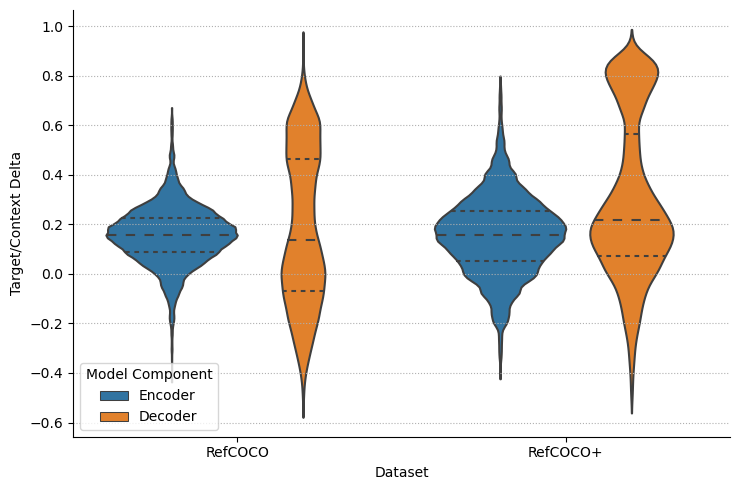

In [9]:
dfs = []
for i, (dataset, df) in enumerate(data['dfs'].items()):
    print (i, dataset)

    dset_label = name_map[dataset]

    samples1 = df.groupby('ann_id').first()['e_tc_delta'].values
    samples2 = df['d_tc_delta'].values

    d1 = pd.DataFrame(pd.Series(samples1, name='values'))
    d1['Dataset'] = dset_label
    d1['Module'] = 'Encoder'

    d2 = pd.DataFrame(pd.Series(samples2, name='values'))
    d2['Dataset'] = dset_label
    d2['Module'] = 'Decoder'

    dfs += [d1, d2]

ds_df = pd.concat(dfs)

p = sns.catplot(
    data=ds_df, x="Dataset", y="values", hue="Module", estimator='mean',
    kind="violin", split=False, orient='v', legend=False, legend_out=False,
    **sns_violin_plot_kwargs, 
    aspect=6/2 if not collapse_test_sets else 3/2
)
plt.legend(title='Model Component', loc='lower left')
plt.ylabel('Target/Context Delta')
plt.grid(axis='y', linestyle= 'dotted')

save_plot(f'EncoderDecoder-Comparison{"-All" if not collapse_test_sets else ""}.png', dpi=300)

plt.show()

0 refcoco
1 refcoco+


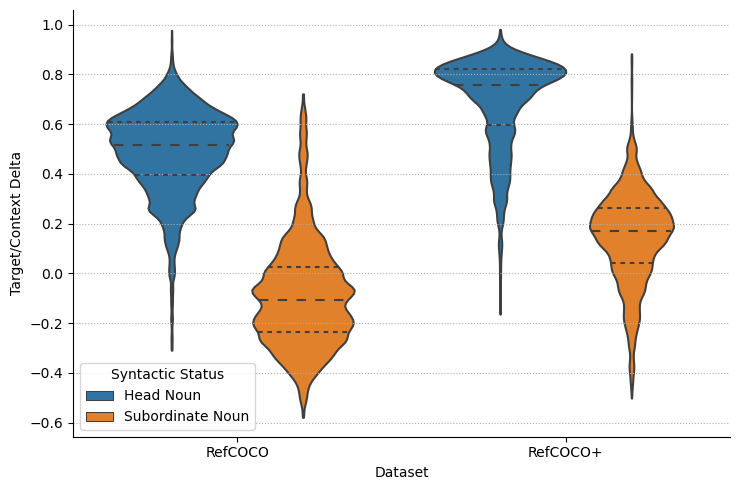

In [10]:
dfs = []
for i, (dataset, df) in enumerate(data['dfs'].items()):
    print (i, dataset)

    dset_label = name_map[dataset]

    independent = 'is_head'
    dependent = 'd_tc_delta'
    samples = independend_dependend_variable_from_df(df[df['pos'] == 'NOUN'], independent, dependent)

    samples1 = samples[True]
    samples2 = samples[False]

    d1 = pd.DataFrame(pd.Series(samples1, name='values'))
    d1['Dataset'] = dset_label
    d1['Syntactic Status'] = 'Head Noun'

    d2 = pd.DataFrame(pd.Series(samples2, name='values'))
    d2['Dataset'] = dset_label
    d2['Syntactic Status'] = 'Subordinate Noun'

    dfs += [d1, d2]

ds_df = pd.concat(dfs)

p = sns.catplot(
    data=ds_df, x="Dataset", y="values", hue="Syntactic Status",
    kind="violin", split=False, orient='v', legend=False, legend_out=False,
    **sns_violin_plot_kwargs, 
    aspect=6/2 if not collapse_test_sets else 3/2
)
plt.legend(title='Syntactic Status',loc='lower left')
plt.ylabel('Target/Context Delta')
plt.grid(axis='y', linestyle= 'dotted')

save_plot(f'HeadSub-Comparison{"-All" if not collapse_test_sets else ""}.png', dpi=300)

plt.show()